In [ ]:
import os
os.chdir("..")

In [1]:
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import Trainer
from ptls.data_load.utils import collate_feature_dict
from torchmetrics.functional import auroc

from src.generation.modules import VanillaAE
from src.preprocessing import preprocess
from src.generation.datasets import SimpleTRXDataset
import torch
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score
from scipy.special import softmax
import numpy as np

from matplotlib import pyplot as plt
from omegaconf import OmegaConf

In [2]:
train, val, test = preprocess(OmegaConf.load("config/preprocessing/churn_ae.yaml")) # type: ignore

[Memory]0.0s, 0.0min    : Loading _preprocess...
__________________________________________preprocess cache loaded - 5.5s, 0.1min


In [3]:
ds = SimpleTRXDataset(val, 40, 20, 20, False)
dl = DataLoader(ds, shuffle=False, collate_fn=collate_feature_dict, batch_size=256)

In [5]:
model = VanillaAE.load_from_checkpoint("macro_micro_coles/xj2hlnjb/checkpoints/epoch=412-step=5369.ckpt")

In [6]:
model.reconstruction_len = 40

In [7]:
trainer = Trainer(False, accelerator="gpu", devices=1)

/home/macro-micro-coles/miniconda/envs/env/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:92: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
mcc_pred = torch.cat([b[0] for b in trainer.predict(model, dl)]).transpose(0, 1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/macro-micro-coles/miniconda/envs/env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [15]:
mcc_pred_np = mcc_pred.cpu().numpy()

In [17]:
large_ds = SimpleTRXDataset(val, 40, 40, 40, False)

In [18]:
mcc_true_np = torch.stack([row["mcc_code"] for row in large_ds], dim=1).cpu().numpy()

In [20]:
mcc_true_np.shape

(40, 338)

In [21]:
aurocs = [
    roc_auc_score(
        target, 
        softmax(preds[:, np.unique(target)], -1), 
        average="macro", 
        multi_class="ovr", 
        labels=np.unique(target)
    )
    for preds, target in zip(mcc_pred_np, mcc_true_np)
]

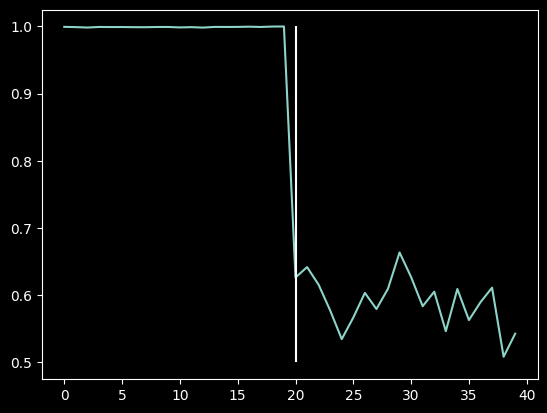

In [25]:
plt.plot(aurocs)
plt.vlines(20, 0.5, 1)

In [29]:
aurocs[20]

0.6264102023635865

In [26]:
np.mean(aurocs[20:])

0.5903546786343837

In [27]:
np.mean(aurocs[:20])

0.9991857343748112